In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

# Dataset

The dataset is about forest fire in Portugal, detailed information can be found here: http://archive.ics.uci.edu/ml/datasets/Forest+Fires

# Atribut Information

For more information, read [Cortez and Morais, 2007].

- X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
- Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
- month - month of the year: 'jan' to 'dec'
- day - day of the week: 'mon' to 'sun'
- FFMC - FFMC index from the FWI system: 18.7 to 96.20
- DMC - DMC index from the FWI system: 1.1 to 291.3
- DC - DC index from the FWI system: 7.9 to 860.6
- ISI - ISI index from the FWI system: 0.0 to 56.10
- temp - temperature in Celsius degrees: 2.2 to 33.30
- RH - relative humidity in %: 15.0 to 100
- wind - wind speed in km/h: 0.40 to 9.40
- rain - outside rain in mm/m2 : 0.0 to 6.4
- area - the burned area of the forest (in ha): 0.00 to 1090.84 (this output variable is very skewed towards 0.0, thus it may make sense to model with the logarithm transform).

In [2]:
data = pd.read_csv('../dataset/forestfires.csv')

In [3]:
data.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


In [4]:
data.shape

(517, 13)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       517 non-null    int64  
 1   Y       517 non-null    int64  
 2   month   517 non-null    object 
 3   day     517 non-null    object 
 4   FFMC    517 non-null    float64
 5   DMC     517 non-null    float64
 6   DC      517 non-null    float64
 7   ISI     517 non-null    float64
 8   temp    517 non-null    float64
 9   RH      517 non-null    int64  
 10  wind    517 non-null    float64
 11  rain    517 non-null    float64
 12  area    517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


# Data Preparation

In [6]:
# Categorize area into 5 groups

data['area_categorical'] = data['area'].apply(lambda x:1 if x > 0 else 0)

In [7]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
data['month'] = encoder.fit_transform(data['month'])
data['day'] = encoder.fit_transform(data['day'])

In [8]:
data['location'] = data['X'].astype('string')+'-'+data['Y'].astype('string')

In [9]:
data['location'] = encoder.fit_transform(data['location'])

In [10]:
data.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,area_categorical,location
0,7,5,7,0,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0,0,25
1,7,4,10,5,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0,0,24
2,7,4,10,2,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0,0,24
3,8,6,7,0,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0,0,30
4,8,6,7,3,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0,0,30


# Base Model

In [11]:
X = data.drop(['area_categorical','area','X','Y'], axis = 1)
y = data['area_categorical']

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                      train_size=0.7, 
                                                      test_size=0.3,
                                                      random_state=0)

In [13]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=0)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [14]:
y_pred = model.predict(X_valid)

In [15]:
from sklearn.metrics import classification_report

print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       0.51      0.52      0.51        69
           1       0.61      0.60      0.60        87

    accuracy                           0.56       156
   macro avg       0.56      0.56      0.56       156
weighted avg       0.57      0.56      0.56       156



In [16]:
from sklearn.metrics import confusion_matrix

pd.DataFrame(confusion_matrix(y_valid, y_pred))

,0,1
0,36,33
1,35,52


# Feature Engineering

## Mutual Information

In [17]:
X = data.drop(['area_categorical','area','X','Y'], axis = 1)
y = data['area_categorical']

In [18]:
from sklearn.feature_selection import mutual_info_classif

def make_mi_scores(X, y):
    mi_scores = mutual_info_classif(X, y, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores= make_mi_scores(X, y)

mi_scores

rain        0.040233
DC          0.038400
DMC         0.038371
temp        0.023900
month       0.022108
location    0.019288
FFMC        0.016533
day         0.013534
ISI         0.012967
RH          0.011050
wind        0.000000
Name: MI Scores, dtype: float64

## Select KBest

In [19]:
X = data.drop(['area_categorical','area','X','Y'], axis = 1)
y = data['area_categorical']

In [20]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

threshold = 5

skb = SelectKBest(score_func=chi2, k=threshold)
sel_skb = skb.fit(X, y)
sel_skb_index = sel_skb.get_support()

In [21]:
sel_skb_index

array([False, False, False,  True,  True, False,  True,  True, False,
       False,  True])

In [24]:
X.columns

Index(['month', 'day', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind',
       'rain', 'location'],
      dtype='object')

## RFE-CV

In [25]:
from sklearn.feature_selection import RFECV

estimator = RandomForestClassifier(random_state=0)
selector = RFECV(estimator, step=1, cv=5)

X = data.drop(['area_categorical','area','X','Y'], axis = 1)
y = data['area_categorical']

selector = selector.fit(X, y)

In [26]:
selector.support_

array([False, False, False,  True, False, False,  True, False, False,
       False, False])

In [27]:
selector.ranking_

array([ 9,  8,  7,  1,  3,  5,  1,  2,  6, 10,  4])

In [28]:
X.columns

Index(['month', 'day', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind',
       'rain', 'location'],
      dtype='object')

## Creating Features

In [49]:
data_create_features = data[['month','area','area_categorical','location']]

In [50]:
data_create_features['month_area'] = data_create_features.groupby("month")["area"].transform("max")

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


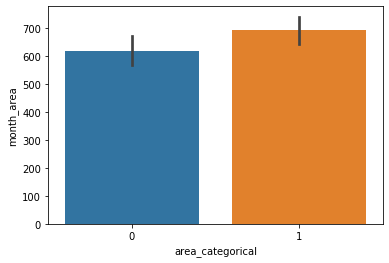

In [51]:
from numpy import mean

sns.barplot(data=data_create_features, x='area_categorical', y='month_area', estimator=mean)

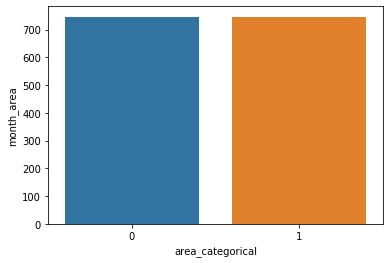

In [52]:
from numpy import median

sns.barplot(data=data_create_features, x='area_categorical', y='month_area', estimator=median)

In [53]:
data_create_features['location_area'] = data_create_features.groupby("location")["area"].transform("max")

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


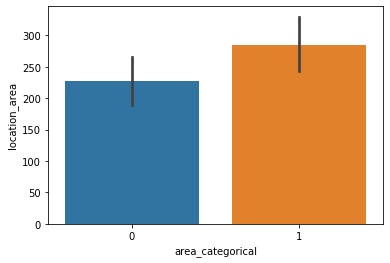

In [54]:
from numpy import mean

sns.barplot(data=data_create_features, x='area_categorical', y='location_area', estimator=mean)

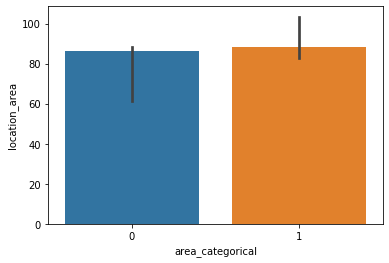

In [55]:
from numpy import mean

sns.barplot(data=data_create_features, x='area_categorical', y='location_area', estimator=median)

## PCA

In [56]:
features = ["FFMC", "DMC", "DC", "ISI", "temp", "RH", "wind", "rain"]

X = data.copy()
y = X.pop('area_categorical')
X = X.loc[:, features]

# Standardize
X_scaled = (X - X.mean(axis=0)) / X.std(axis=0)

In [57]:
X_scaled

,FFMC,DMC,DC,ISI,temp,RH,wind,rain
0,-0.805180,-1.322045,-1.828706,-0.860113,-1.840857,0.411326,1.497164,-0.073197
1,-0.008094,-1.178399,0.488418,-0.509195,-0.153130,-0.691786,-1.740070,-0.073197
2,-0.008094,-1.048806,0.560173,-0.509195,-0.738668,-0.691786,-1.516813,-0.073197
3,0.191177,-1.211188,-1.896429,-0.004751,-1.823636,3.230391,-0.009824,0.602572
4,-0.243597,-0.930142,-1.796859,0.126843,-1.289763,3.352959,-1.237741,-0.073197
...,...,...,...,...,...,...,...,...
512,-1.638496,-0.845829,0.474309,-1.561947,1.534597,-0.753070,-0.735411,-0.073197
513,-1.638496,-0.845829,0.474309,-1.561947,0.518517,1.637006,0.994835,-0.073197
514,-1.638496,-0.845829,0.474309,-1.561947,0.397965,1.575722,1.497164,-0.073197
515,0.680298,0.548471,0.269122,0.499693,1.155720,-0.140230,-0.009824,-0.073197


In [58]:
from sklearn.decomposition import PCA

# Create principal components
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Convert to dataframe
component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=component_names)

X_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
0,3.205864,-0.449746,1.191865,-0.270653,-0.277244,-0.396669,-0.200855,0.191556
1,0.191123,-0.692362,-1.605626,0.744391,0.771772,-0.283774,1.046486,0.049025
2,0.417331,-0.494474,-1.383260,0.544689,0.716483,-0.507917,1.182410,0.453021
3,2.861723,1.579701,1.397983,-0.077050,2.294466,-0.346146,-0.431576,-1.004190
4,2.485793,1.644534,0.134450,-0.304417,2.811045,0.304818,-0.699337,-1.064944


In [59]:
loadings = pd.DataFrame(
    pca.components_.T,  # transpose the matrix of loadings
    columns=component_names,  # so the columns are the principal components
    index=X.columns,  # and the rows are the original features
)
loadings

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
FFMC,-0.427646,-0.164512,0.262415,-0.090728,0.356059,-0.733082,-0.022399,-0.219712
DMC,-0.433508,0.445561,-0.046162,-0.161058,-0.201189,-0.053325,-0.594775,0.434048
DC,-0.433127,0.368681,-0.213008,-0.099721,-0.287602,-0.053672,0.731780,-0.007852
ISI,-0.364291,-0.101598,0.463690,-0.184787,0.450910,0.569518,0.166800,0.228742
temp,-0.487721,-0.211550,-0.147386,0.190811,-0.224830,0.347814,-0.268758,-0.644585
RH,0.229028,0.711330,0.126116,-0.195015,0.318682,0.089378,-0.086464,-0.520190
wind,0.124913,-0.045594,0.704710,-0.268516,-0.628091,-0.043547,0.013998,-0.130428
rain,-0.054359,0.274483,0.366583,0.880453,-0.010291,-0.040709,0.050144,0.088574


In [60]:
def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

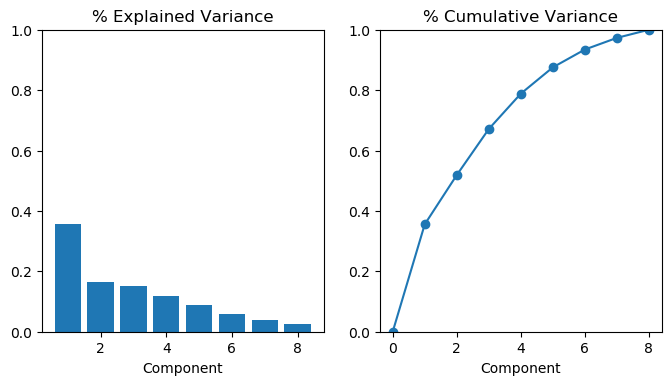

In [61]:
# Look at explained variance
plot_variance(pca);

In [62]:
mi_scores = make_mi_scores(X_pca, y, discrete_features=False)
mi_scores

PC1    0.041200
PC5    0.030245
PC2    0.018449
PC7    0.010831
PC4    0.009220
PC8    0.000734
PC3    0.000000
PC6    0.000000
Name: MI Scores, dtype: float64

# Model

In [113]:
X = data.drop(['area_categorical','X','Y'], axis = 1)
y = data['area_categorical']

In [114]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                      train_size=0.8, 
                                                      test_size=0.2,
                                                      random_state=0)

In [115]:
X_train["area_month_max"] = X_train.groupby("month")["area"].transform("max")

# Merge the values into the validation set
X_valid = X_valid.merge(
    X_train[["month", "area_month_max"]].drop_duplicates(),
    on="month",
    how="left",
)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [116]:
X_train = X_train.drop(['area'], axis = 1)
X_valid = X_valid.drop(['area'], axis = 1)

## Testing Model - RF

In [129]:
Xx_train = X_train[['DMC','DC','temp','location','area_month_max']]
Xx_valid = X_valid[['DMC','DC','temp','location','area_month_max']]

In [130]:
model = RandomForestClassifier(random_state=0)
model.fit(Xx_train, y_train)

RandomForestClassifier(random_state=0)

In [131]:
Xx_valid.isnull().any()

DMC               False
DC                False
temp              False
location          False
area_month_max    False
dtype: bool

In [132]:
y_pred = model.predict(Xx_valid)

In [133]:
from sklearn.metrics import classification_report

print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       0.52      0.57      0.54        44
           1       0.66      0.62      0.64        60

    accuracy                           0.60       104
   macro avg       0.59      0.59      0.59       104
weighted avg       0.60      0.60      0.60       104



In [134]:
from sklearn.metrics import confusion_matrix

pd.DataFrame(confusion_matrix(y_valid, y_pred))

,0,1
0,25,19
1,23,37


# ANN

In [366]:
import tensorflow
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout

# Hyperparameter Tuning

- Epoch
- Batch Size
- Learning Rate
- Optimizer
- Activation Function
- Neuron
- Layer

# Base Model - NN Architecture

In [412]:
# Define Model

model = Sequential()

model.add(Dense(14, input_shape=(5,), activation='relu', kernel_initializer = 'he_uniform'))
model.add(Dropout(rate=0.1))

model.add(Dense(14, activation='relu', kernel_initializer = 'he_uniform'))
model.add(Dropout(rate=0.1))

model.add(Dense(14, activation='relu', kernel_initializer = 'he_uniform'))
model.add(Dropout(rate=0.1))

model.add(Dense(1, activation='sigmoid'))

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[tensorflow.keras.metrics.AUC()])
    
# Fit model
history = model.fit(Xx_train, y_train, validation_data=(Xx_valid, y_valid), epochs=100, verbose=0, batch_size=64)


In [413]:
y_pred = model.predict_classes(Xx_valid)

In [414]:
from sklearn.metrics import classification_report

print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       0.48      0.27      0.35        44
           1       0.59      0.78      0.68        60

    accuracy                           0.57       104
   macro avg       0.54      0.53      0.51       104
weighted avg       0.55      0.57      0.54       104



In [415]:
from sklearn.metrics import confusion_matrix

pd.DataFrame(confusion_matrix(y_valid, y_pred))

,0,1
0,12,32
1,13,47


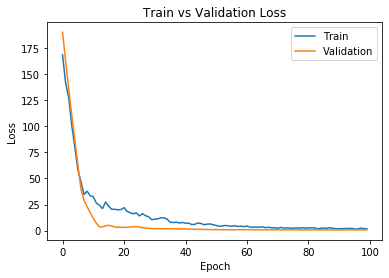

In [416]:
# plot train and validation loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Train vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

---